# Fake/True News Detection torch RoBERTa and PEFT

In [ ]:
pip install peft

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install chardet

In [33]:
debug = False
debug2 = False

In [34]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import transformers
import random
import chardet
import warnings
warnings.simplefilter('ignore')
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [35]:
def random_seed(SEED):

    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

SEED = 508
random_seed(SEED)

In [36]:
# fake = pd.read_csv('Fake.csv')
# fake['label'] = 'fake'

# true = pd.read_csv('True.csv')
# true['label'] = 'true'

# data = pd.concat([fake[['label', 'title', 'text']], true[['label', 'title', 'text']]], axis=0).reset_index(drop=True)

# n = len(data)
# N = list(range(n))
# random.shuffle(N)
# data = data.iloc[N]
# display(data)


In [37]:
fake=pd.read_csv('Fake.csv')
fake['label']='fake'
true=pd.read_csv('True.csv')
true['label']='true'
data=pd.concat([fake[['label','text']],true[['label','text']]],axis=0).reset_index(drop=True)
n=len(data)
N=list(range(n))
random.shuffle(N)
data=data.iloc[N]
display(data)

,label,text
5871,fake,From the very outset of Trump s improbable pol...
4569,fake,"A Dallas police officer, seeing red after seve..."
10001,fake,Who hasn t seen his commercials over and over ...
25465,true,"WASHINGTON/AUSTIN, Texas (Reuters) - The U.S. ..."
13014,fake,
...,...,...
4532,fake,World-renowned writer/director Joss Whedon has...
32429,true,(Reuters) - Presumptive Democratic presidentia...
27497,true,WASHINGTON (Reuters) - Here are some of the hi...
43492,true,MOSCOW (Reuters) - Russian Foreign Minister Se...


In [38]:
# class_names = sorted(data['label'].unique().tolist())
# print(class_names)

# N = list(range(len(class_names)))
# normal_mapping = dict(zip(class_names, N))
# reverse_mapping = dict(zip(N, class_names))

# data['label'] = data['label'].map(normal_mapping)


In [39]:
data.columns=['label','text']
class_names=sorted(data['label'].unique().tolist())
print(class_names)
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))
data['label']=data['label'].map(normal_mapping)

['fake', 'true']


In [40]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data[0:3000], test_size=0.2, random_state=42)

In [41]:
tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base")

In [42]:
# test_s = train['title'].iloc[0] + " " + train['text'].iloc[0]


In [43]:
test_s = train['text'].iloc[0]

result1 = tokenizer.encode_plus(test_s)

tokenizer.decode(result1["input_ids"])

Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors


'<s>APOPKA, Fla. (Reuters) - With Hurricane Irma barreling down on Central Florida, Apopka resident Carmen Nova had a decision to make.  A Mexican immigrant living in the country illegally, she knew her mobile home was at risk in the storm. But the 30-year-old mother of three also knew that seeking protection could pose its own hazards.  In a time of increasing public sentiment against illegal immigration, undocumented immigrants like Nova are nervous about reporting to authorities, even if it is to take refuge from a hurricane.  There s an internal storm, there s an external storm, and there s a political storm, and they re all targeting this community,  said Sister Ann Kendrick, a Roman Catholic nun, community organizer and immigrant rights advocate.  They re getting hammered,  said Kendrick, who has worked hard in advance of the hurricane to convince undocumented immigrants that it is safer to take shelter than to remain in less-than-sturdy homes. Like other counties in Florida, Apo

In [44]:
len(test_s.split(" "))

570

In [45]:
result2 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True,
    max_length = 32,
    pad_to_max_length = True,
    truncation = True
)

In [46]:
tokenizer.decode(result2["input_ids"])

'<s>APOPKA, Fla. (Reuters) - With Hurricane Irma barreling down on Central Florida, Apopka resident Carmen Nova had a decision</s>'

In [47]:
max_sens = 32

train = train.sort_values("label").reset_index(drop=True)

train["kfold"] = train.index % 5

p_train = train[train["kfold"]!=0].reset_index(drop=True)
p_valid = train[train["kfold"]==0].reset_index(drop=True)

p_test=test.reset_index(drop=True)

'token_type_ids' no need in RoBERTa/DeBERTa

In [48]:
class BERTDataSet(Dataset):

    def __init__(self,sentences,targets):
        self.sentences = sentences
        self.targets = targets

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True,
                                max_length = max_sens,
                                pad_to_max_length = True,
                                return_attention_mask = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)

        target = torch.tensor(self.targets[idx],dtype=torch.float)

        return {
                'ids': ids,
                'mask': mask,

                'targets': target
            }

In [49]:
train_dataset = BERTDataSet(p_train["text"],p_train["label"])
valid_dataset = BERTDataSet(p_valid["text"],p_valid["label"])
test_dataset = BERTDataSet(p_test["text"],p_test["label"])

train_batch = 16
valid_batch = 32
test_batch = 32

train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=8,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=8,pin_memory=True)
test_dataloader = DataLoader(test_dataset,batch_size=test_batch,shuffle = False,num_workers=8,pin_memory=True)

In [50]:
model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=2)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [51]:
#peft setting for roberta

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

lora_model = get_peft_model(model, lora_config)
model = lora_model
display(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [52]:
model.to(device)
model.train()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [53]:
for a in train_dataloader:
    ids = a["ids"].to(device)
    mask = a["mask"].to(device)

    output = model(ids,mask)
    break

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [54]:
output = output["logits"].squeeze(-1).shape

In [55]:
from torch.optim import AdamW
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2)

In [56]:
# set epochs
from transformers import get_linear_schedule_with_warmup
epochs = 4
if debug:
 epochs = 1
train_steps = int(len(p_train)/train_batch*epochs)
print(train_steps)
num_steps = int(train_steps*0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

480


In [57]:
def loss_fn(output,target):
    return torch.nn.CrossEntropyLoss()(output, target.long()) # torch.sqrt(nn.MSELoss()(output,target))

In [58]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import torch.nn.functional as F


def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []

    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)  # shape: [batch_size], values: 0 or 1

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # shape: [batch_size, 2]

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    acc = accuracy_score(all_targets, all_preds)

    return avg_loss, f1, acc

def validating(valid_dataloader, model):
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in valid_dataloader:
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["targets"].to(device).long()

            outputs = model(input_ids=ids, attention_mask=mask)
            logits = outputs.logits

            loss = loss_fn(logits, targets)  # explicitly compute loss here
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss / len(valid_dataloader)
    val_f1 = f1_score(all_targets, all_preds, average='weighted')
    val_acc = accuracy_score(all_targets, all_preds)

    return avg_loss, val_f1, val_acc, all_preds, all_targets


# Train and Validate

In [66]:
# if not debug2:
#     train_losses = []
#     valid_losses = []
#     valid_f1s = []
#     valid_accs = []

#     for epoch in range(epochs):
#         print(f"Epoch {epoch + 1}/{epochs}")

#         # Training
#         train_loss, train_f1, train_acc = training(train_dataloader, model, optimizer, scheduler)
#         print(f"Train Loss: {train_loss:.4f} | F1 Score: {train_f1:.4f} | Accuracy: {train_acc:.4f}")

#         # Validation
#         val_loss, val_f1, val_acc, val_preds, val_targets = validating(valid_dataloader, model)
#         print(f"Valid Loss: {val_loss:.4f} | F1 Score: {val_f1:.4f} | Accuracy: {val_acc:.4f}")

#         # Store for plotting
#         train_losses.append(train_loss)
#         valid_losses.append(val_loss)
#         valid_f1s.append(val_f1)
#         valid_accs.append(val_acc)


In [59]:
new_test = pd.read_csv("fake_and_real_news.csv")
label_map = {"Fake": 0, "Real": 1}
new_test['label'] = new_test['label'].map(label_map)

def testing(test_dataloader, model):
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in test_dataloader:
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["targets"].to(device).long()

            outputs = model(input_ids=ids, attention_mask=mask)
            logits = outputs.logits

            loss = loss_fn(logits, targets)  # explicitly compute loss
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss / len(test_dataloader)
    test_f1 = f1_score(all_targets, all_preds, average='weighted')
    test_acc = accuracy_score(all_targets, all_preds)

    return avg_loss, test_f1, test_acc, all_preds, all_targets


In [60]:
if not debug2:
    train_losses = []
    valid_losses = []
    valid_f1s = []
    valid_accs = []
    test_losses = []
    test_f1s = []
    test_accs = []

    valid_all_targets = []
    test_all_targets = []
    test_all_preds = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training
        train_loss, train_f1, train_acc = training(train_dataloader, model, optimizer, scheduler)
        print(f"Train Loss: {train_loss:.4f} | F1 Score: {train_f1:.4f} | Accuracy: {train_acc:.4f}")

        # Validation
        val_loss, val_f1, val_acc, val_preds, val_targets = validating(valid_dataloader, model)
        print(f"Valid Loss: {val_loss:.4f} | F1 Score: {val_f1:.4f} | Accuracy: {val_acc:.4f}")

        # Testing
        test_loss, test_f1, test_acc, test_preds, test_targets = testing(test_dataloader, model)
        print(f"Test Loss: {test_loss:.4f} | F1 Score: {test_f1:.4f} | Accuracy: {test_acc:.4f}")

        # Store for plotting
        train_losses.append(train_loss)
        valid_losses.append(val_loss)
        valid_f1s.append(val_f1)
        valid_accs.append(val_acc)
        test_losses.append(test_loss)
        test_f1s.append(test_f1)
        test_accs.append(test_acc)

        valid_all_targets.append(val_targets)
        test_all_targets.append(test_targets)
        test_all_preds.append(test_preds)

Epoch 1/4


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train Loss: 0.6785 | F1 Score: 0.6132 | Accuracy: 0.6234


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Valid Loss: 0.6424 | F1 Score: 0.9708 | Accuracy: 0.9708


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Test Loss: 0.6402 | F1 Score: 0.9733 | Accuracy: 0.9733
Epoch 2/4


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train Loss: 0.4800 | F1 Score: 0.9729 | Accuracy: 0.9729


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Valid Loss: 0.2241 | F1 Score: 0.9937 | Accuracy: 0.9938


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Test Loss: 0.2305 | F1 Score: 0.9933 | Accuracy: 0.9933
Epoch 3/4


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train Loss: 0.1212 | F1 Score: 0.9974 | Accuracy: 0.9974


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Valid Loss: 0.0470 | F1 Score: 0.9937 | Accuracy: 0.9938


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Test Loss: 0.0535 | F1 Score: 0.9933 | Accuracy: 0.9933
Epoch 4/4


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train Loss: 0.0424 | F1 Score: 0.9958 | Accuracy: 0.9958


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Valid Loss: 0.0352 | F1 Score: 0.9937 | Accuracy: 0.9938


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Test Loss: 0.0422 | F1 Score: 0.9917 | Accuracy: 0.9917


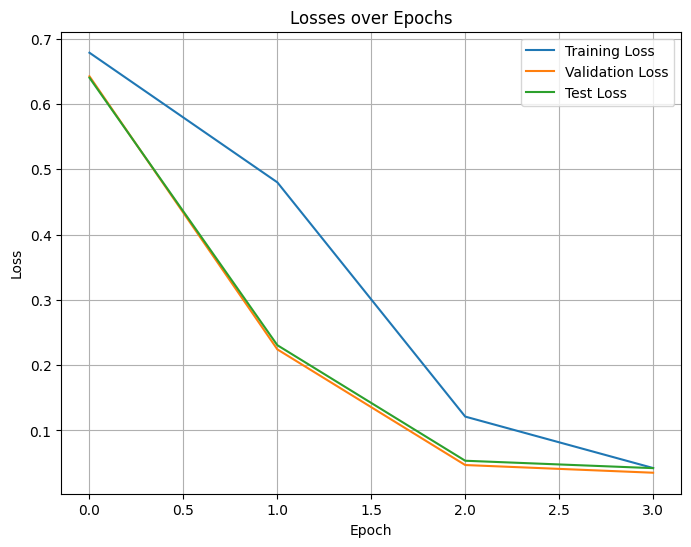

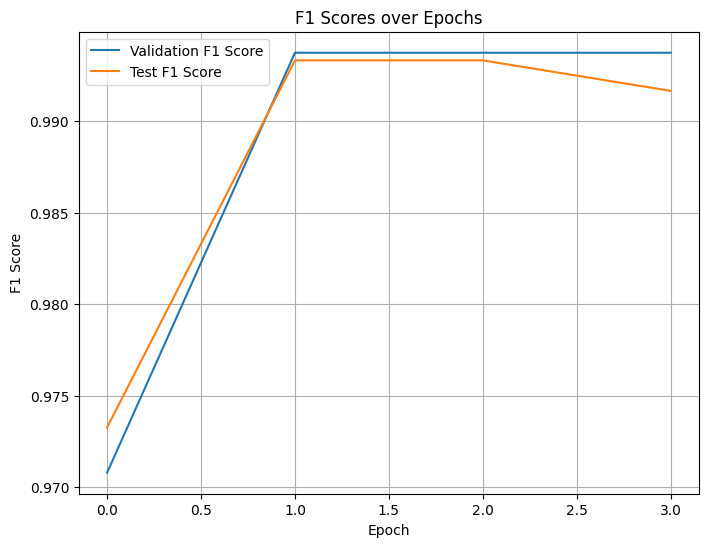

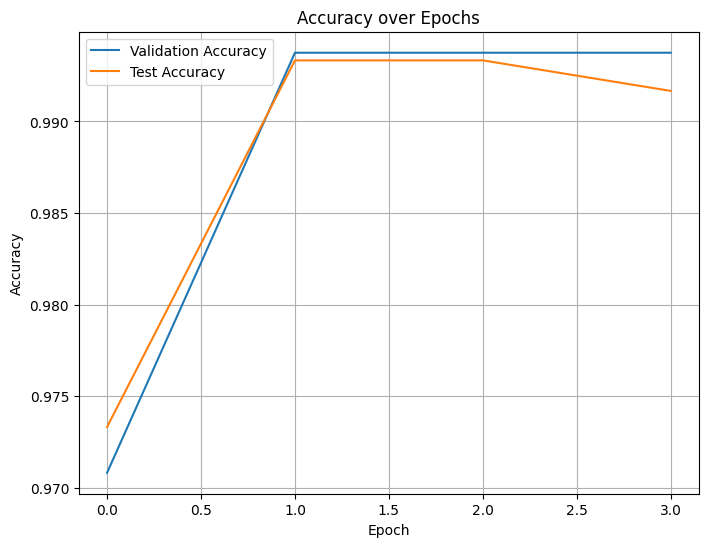

In [62]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(epochs)

# Plot Training, Validation, and Test Losses
plt.figure(figsize=(8,6))
plt.plot(x, train_losses, label='Training Loss')
plt.plot(x, valid_losses, label='Validation Loss')
plt.plot(x, test_losses, label='Test Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation and Test F1 Scores
plt.figure(figsize=(8,6))
plt.plot(x, valid_f1s, label='Validation F1 Score')
plt.plot(x, test_f1s, label='Test F1 Score')
plt.title('F1 Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation and Test Accuracies
plt.figure(figsize=(8,6))
plt.plot(x, valid_accs, label='Validation Accuracy')
plt.plot(x, test_accs, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

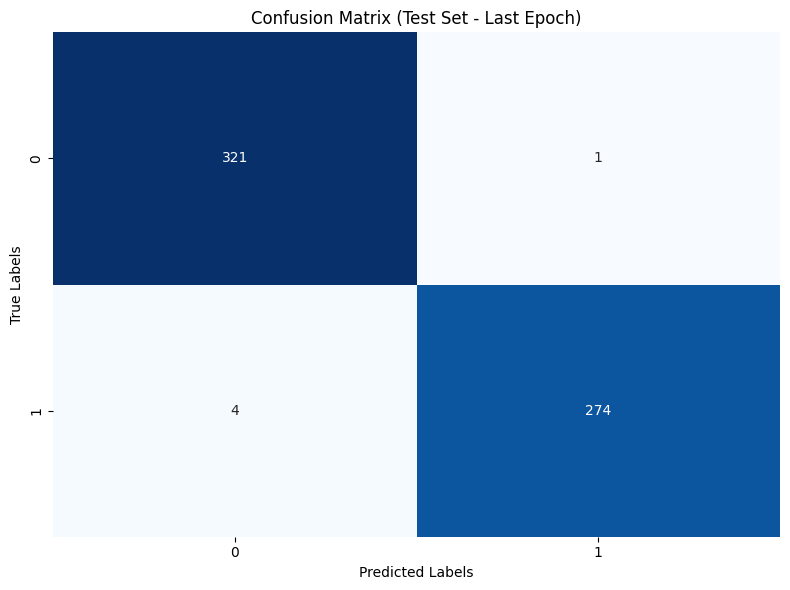

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions and true labels from last epoch
actuals = test_all_targets[-1]
preds = test_all_preds[-1]

# Compute confusion matrix
cm = confusion_matrix(actuals, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Test Set - Last Epoch)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [67]:
pip install transformers faiss-cpu datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 38.2 MB/s eta 0:00:00


In [68]:
model.save_pretrained("lora_roberta_adapter")
tokenizer.save_pretrained("lora_roberta_adapter")

('lora_roberta_adapter/tokenizer_config.json',
 'lora_roberta_adapter/special_tokens_map.json',
 'lora_roberta_adapter/vocab.json',
 'lora_roberta_adapter/merges.txt',
 'lora_roberta_adapter/added_tokens.json')

In [74]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from peft import PeftModel
import torch
import torch.nn.functional as F

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load your base model + LoRA
base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model = PeftModel.from_pretrained(base_model, "./lora_roberta_adapter")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [76]:
pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=f8c6c9bf1432a29a47702422e6b8de97a3d5b30709f056bd12a4e791df134261
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


# **Retrieval Augmented Generation**

In [77]:
pip install spacy

In [78]:
import wikipedia
import re

def get_main_entities_spacy(claim):
    # Optional: use spaCy if installed for better entity extraction
    try:
        import spacy
        nlp = spacy.load("en_core_web_sm")
        doc = nlp(claim)
        ents = [ent.text for ent in doc.ents if ent.label_ in ("PERSON", "ORG", "GPE", "LOC", "EVENT", "WORK_OF_ART")]
        if ents:
            return ents
    except Exception:
        pass
    # fallback simple regex extract capitalized words of length >= 3
    caps = re.findall(r'\b[A-Z][a-z]{2,}\b', claim)
    return caps if caps else [claim]

def get_wikipedia_summary(claim, sentences=3):
    """
    Attempts to retrieve the best Wikipedia summary for a claim by:
    - Trying full claim first
    - Then trying extracted entities from claim
    - Then falling back to search results with best heuristics
    """

    def try_summary(title):
        try:
            return wikipedia.summary(title, sentences=sentences)
        except wikipedia.DisambiguationError as e:
            # Try the first option from disambiguation list heuristically
            for option in e.options:
                if option.lower() in title.lower() or title.lower() in option.lower():
                    try:
                        return wikipedia.summary(option, sentences=sentences)
                    except:
                        continue
            # If no good option found, try first one anyway
            try:
                return wikipedia.summary(e.options[0], sentences=sentences)
            except:
                return ""
        except Exception:
            return ""

    # 1) Try full claim as title
    summary = try_summary(claim)
    if summary:
        return summary

    # 2) Try extracted entities
    entities = get_main_entities_spacy(claim)
    for ent in entities:
        summary = try_summary(ent)
        if summary:
            return summary

    # 3) Try wikipedia search results with some filtering
    search_results = wikipedia.search(claim, results=5)
    for res in search_results:
        # Avoid trivial/wrong matches like single letters or too generic terms
        if len(res) < 3 or re.match(r'^[A-Z]$', res):
            continue
        summary = try_summary(res)
        if summary:
            return summary

    return "No relevant Wikipedia context found."


In [79]:
# Test examples:
claims = [
    "The Eiffel Tower is located in Paris.",
    "Barack Obama was born in Kenya.",
    "COVID-19 vaccines contain microchips.",
    "The Taj Mahal is located in Mumbai.",
    "COVID-19 vaccines have been authorized by the WHO."
]

for claim in claims:
    print(f"CLAIM: {claim}")
    context = get_wikipedia_summary(claim)
    print(f"Wikipedia Context: {context}\n{'-'*80}")


CLAIM: The Eiffel Tower is located in Paris.
Wikipedia Context: The Eiffel Tower (  EYE-fəl; French: Tour Eiffel [tuʁ ɛfɛl] ) is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower from 1887 to 1889.
Locally nicknamed "La dame de fer" (French for "Iron Lady"), it was constructed as the centrepiece of the 1889 World's Fair, and to crown the centennial anniversary of the French Revolution.
--------------------------------------------------------------------------------
CLAIM: Barack Obama was born in Kenya.
Wikipedia Context: Abon'go Malik "Roy" Obama (born March 17 1958) is a Kenyan-American businessman and former political candidate known for being the paternal half-brother of 44th president of the United States, Barack Obama, and the eldest son of economist Barack Obama Sr.


== Biography ==
Abon'go Malik "Roy" Obama was born and raised in Nairobi, Kenya. His parents are economist

In [86]:
import torch.nn.functional as F
import torch

def predict_with_model(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Ensure tensors are on same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()

    return pred, confidence

In [87]:
def compare_with_improved_rag(claim):
    # Prediction without RAG (just claim)
    pred_no_rag, conf_no_rag = predict_with_model(claim)

    # Get improved Wikipedia context
    context = get_wikipedia_summary(claim)

    # Prepare enriched input combining context and claim
    enriched_input = f"Context: {context}\nClaim: {claim}" if context else claim

    # Prediction with RAG (context + claim)
    pred_rag, conf_rag = predict_with_model(enriched_input)

    # Display results clearly
    print(f"\nCLAIM: {claim}")
    print(f"=== Without RAG ===")
    print(f"Prediction : {pred_no_rag} | Confidence: {conf_no_rag:.4f}")
    print(f"\n=== With RAG (Wikipedia) ===")
    print(f"Prediction : {pred_rag} | Confidence: {conf_rag:.4f}")
    print(f"Wikipedia Context (truncated to 300 chars): {context[:300]}...\n")

    return {
        "claim": claim,
        "no_rag_pred": pred_no_rag,
        "no_rag_conf": conf_no_rag,
        "rag_pred": pred_rag,
        "rag_conf": conf_rag,
        "context": context
    }


In [88]:
claims = [
    "The Eiffel Tower is located in Paris.",
    "Barack Obama was born in Kenya.",
    "COVID-19 vaccines contain microchips.",
    "The Taj Mahal is located in Mumbai.",
    "COVID-19 vaccines have been authorized by the WHO."
]

for claim in claims:
    compare_with_improved_rag(claim)



CLAIM: The Eiffel Tower is located in Paris.
=== Without RAG ===
Prediction : 0 | Confidence: 0.8990

=== With RAG (Wikipedia) ===
Prediction : 0 | Confidence: 0.9005
Wikipedia Context (truncated to 300 chars): The Eiffel Tower (  EYE-fəl; French: Tour Eiffel [tuʁ ɛfɛl] ) is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower from 1887 to 1889.
Locally nicknamed "La dame de fer" (French for "Iron Lady"...


CLAIM: Barack Obama was born in Kenya.
=== Without RAG ===
Prediction : 0 | Confidence: 0.9633

=== With RAG (Wikipedia) ===
Prediction : 0 | Confidence: 0.9426
Wikipedia Context (truncated to 300 chars): Abon'go Malik "Roy" Obama (born March 17 1958) is a Kenyan-American businessman and former political candidate known for being the paternal half-brother of 44th president of the United States, Barack Obama, and the eldest son of economist Barack Obama Sr.


== Biography ==
Abo